In [1]:
import delfi
print(delfi.__version__)

0.4.1


In [125]:
from delfi.simulator import GaussMixture

n_params = 1
m = GaussMixture(dim=n_params)

In [130]:
from delfi.simulator.BaseSimulator import BaseSimulator

class MyGaussMixture(BaseSimulator):
    def __init__(self, dim=1, noise_cov=[1.0, 0.1], seed=None):
        """Gaussian Mixture simulator
        Toy model that draws data from a mixture distribution with 2 components
        that have mean theta and fixed noise.
        Parameters
        ----------
        dim : int
            Number of dimensions of parameters
        noise_cov : list
            Covariance of noise on observations
        seed : int or None
            If set, randomness is seeded
        """
        super().__init__(dim_param=dim, seed=seed)
        self.a = [0.5, 0.5]  # mixture weights
        self.noise_cov = [nc*np.eye(dim) for nc in noise_cov]

    @copy_ancestor_docstring
    def gen_single(self, param):
        # See BaseSimulator for docstring
        param = np.asarray(param).reshape(-1)
        assert param.ndim == 1
        assert param.shape[0] == self.dim_param

        samples = dd.MoG(a=self.a, ms=[param for p in range(2)],
                        Ss=self.noise_cov, seed=self.gen_newseed()).gen(2)

        return {'data': samples.reshape(-1)}

In [131]:
n_params = 1
mygm = MyGaussMixture(dim=n_params)

In [132]:
import delfi.distribution as dd
import numpy as np

p = dd.Uniform(lower=[-10], upper=[10])

In [133]:
from delfi.summarystats import Identity

s = Identity()

In [134]:
from delfi.generator import Default

g = Default(model=mygm, prior=p, summary=s)

In [135]:
params, stats = g.gen(500)

In [109]:
import matplotlib.pyplot as plt
%matplotlib inline

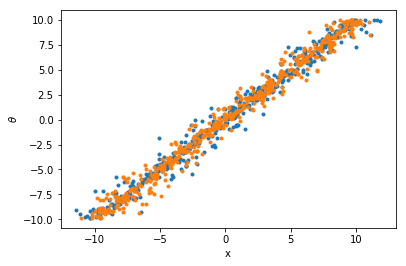

In [136]:
plt.plot(stats, params, '.')
plt.ylabel(r'$\theta$')
plt.xlabel(r'x');

In [138]:
stats.shape

(500, 2)

In [139]:
from delfi.inference import Basic

inf_basic = Basic(generator=g, n_components=2, n_hiddens=[10])

In [140]:
log, train_data, _ = inf_basic.run(n_train=5000)

(0, 8)

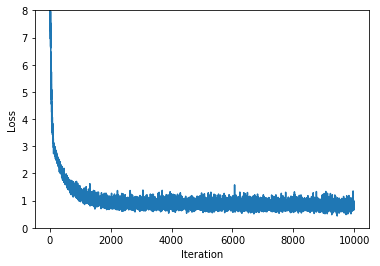

In [141]:
plt.plot(log['loss'])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.ylim([0, 8])

In [147]:
xo = np.array([[0., 0.01]])
posterior = inf_basic.predict(xo)

In [148]:
for k in range(2):
    print(r'component {}: mixture weight = {:.2f}; mean = {:.2f}; variance = {:.2f}'.format(
        k+1, posterior.a[k], posterior.xs[k].m[0], posterior.xs[k].S[0][0]))

component 1: mixture weight = 0.50; mean = 0.07; variance = 0.18
component 2: mixture weight = 0.50; mean = -0.05; variance = 0.18


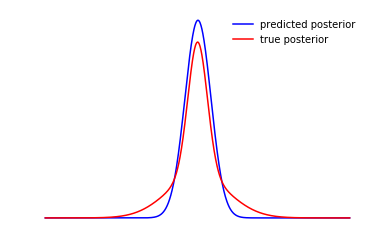

In [149]:
true_posterior = dd.MoG(a=[0.5, 0.5], ms=[[0.], [0.]], Ss=[[[1.0]], [[0.1]]])
plt.plot(posterior.eval(np.arange(-5.0, 5.0, 0.01).reshape(-1,1), log=False), '-b')
plt.plot(true_posterior.eval(np.arange(-5.0, 5.0, 0.01).reshape(-1,1), log=False), '-r')
plt.legend(['predicted posterior', 'true posterior'], frameon=False)
plt.axis('off');

## SNPE

In [152]:
from delfi.inference import SNPE

xo = np.array([[0., 0.001]])
inf_snpe = SNPE(generator=g, n_components=2, n_hiddens=[10], obs=xo)
logs, tds, posteriors = inf_snpe.run(n_train=[2000, 1000], n_rounds=2)
posterior = posteriors[-1]

component 1: mixture weight = 0.69; mean = 0.06; variance = 0.13
component 2: mixture weight = 0.31; mean = -0.20; variance = 0.23


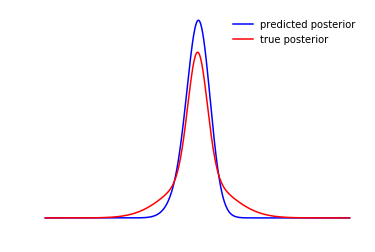

In [153]:
for k in range(2):
    print(r'component {}: mixture weight = {:.2f}; mean = {:.2f}; variance = {:.2f}'.format(
        k+1, posterior.a[k], posterior.xs[k].m[0], posterior.xs[k].S[0][0]))

true_posterior = dd.MoG(a=[0.5, 0.5], ms=[[0.], [0.]], Ss=[[[1.0]], [[0.1]]])
plt.plot(posterior.eval(np.arange(-5.0, 5.0, 0.01).reshape(-1,1), log=False), '-b')
plt.plot(true_posterior.eval(np.arange(-5.0, 5.0, 0.01).reshape(-1,1), log=False), '-r')
plt.legend(['predicted posterior', 'true posterior'], frameon=False)
plt.axis('off');

In [194]:
from delfi.simulator.BaseSimulator import BaseSimulator
import models as md

class GaussMixture(BaseSimulator):
    def __init__(self, dim=1, noise_cov=[1.0, 0.1], seed=None):
        """Gaussian Mixture simulator
        Toy model that draws data from a mixture distribution with 2 components
        that have mean theta and fixed noise.
        Parameters
        ----------
        dim : int
            Number of dimensions of parameters
        noise_cov : list
            Covariance of noise on observations
        seed : int or None
            If set, randomness is seeded
        """
        super().__init__(dim_param=dim, seed=seed)
        self.a = [0.5, 0.5]  # mixture weights
        self.noise_cov = [nc*np.eye(dim) for nc in noise_cov]

    @copy_ancestor_docstring
    def gen_single(self, param):
        # See BaseSimulator for docstring
        param = np.asarray(param).reshape(-1)
        assert param.ndim == 1
        assert param.shape[0] == self.dim_param

        sample = dd.MoG(a=self.a, ms=[param for p in range(2)],
                        Ss=self.noise_cov, seed=self.gen_newseed()).gen(1)

        return {'data': sample.reshape(-1)}
    
class LIF(BaseSimulator):
    def __init__(self, dim=1, seed=None, fixed_params=None):
        """Leaky Integrate-and-Fire simulator
        Integrates input until a given threshold is reached at which we
        define the response time.
        Parameters
        ----------
        dim : int
            Number of dimensions of parameters
        noise_cov : list
            Covariance of noise on observations
        seed : int or None
            If set, randomness is seeded
        """
        super().__init__(dim_param=dim, seed=seed)
        self.fixed_params = fixed_params

    @copy_ancestor_docstring
    def gen_single(self, param):
        # See BaseSimulator for docstring
        param = np.asarray(param).reshape(-1)
        assert param.ndim == 1
        assert param.shape[0] == self.dim_param

        model_params = self.fixed_params.copy()
        model_params['m'] = param
        nruns = 50
        rstims = np.zeros((1, nruns))
        lvs = np.zeros((1, nruns))
        for i in np.arange(nruns):
            rstims[0, i], rdist, reaction_time, lvs[0, i], stim_size, speed, rtime_to_coll = md.calc_response(params)

        data = np.concatenate((rstims, lvs), axis=1)
        return {'data': data}

In [195]:
total_time = 5
dt = 0.001
params = {'tau_m': 0.023,
          'e_l': -0.079,
          'r_m': 10*1e6,
          'v_t': -0.061,
          'init_vm_std': 0.000,
          'vt_std': 0.000,
          'dt': dt,
          'total_time': total_time,
          'init_period': 0,
          'noise_std': 5*1e-3,
          'n_timepoints': int(total_time/dt),
          'm': 5,
          'b': 0,
          'cutoff_angle': 180}

lifm = LIF(fixed_params=params)

In [196]:
p = dd.Uniform(lower=[1], upper=[8])

In [197]:
g = Default(model=lifm, prior=p, summary=s)

In [198]:
gparams, stats = g.gen(500)

In [199]:
stats.shape

(500, 100)

Text(0.5,1,'m = [ 2.3626962]')

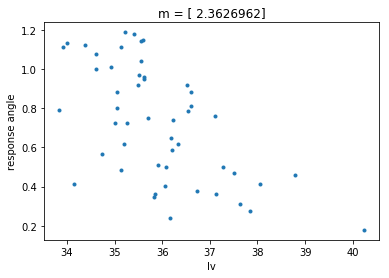

In [200]:
plt.plot(stats[0, 0:50], stats[0, 50:], '.')
plt.ylabel(r'response angle')
plt.xlabel(r'lv')
plt.title('m = ' + str(gparams[0]))

In [209]:
from delfi.inference import SNPE

ostims = np.random.normal(loc=35, scale=1, size=50)
olvs = np.random.normal(loc=0.5, scale=0.001, size=50)
xo = np.concatenate((ostims, olvs)).reshape((1, 100))
#xo = np.array([[35]])
inf_snpe = SNPE(generator=g, n_components=2, n_hiddens=[10], obs=xo)
logs, tds, posteriors = inf_snpe.run(n_train=[2000, 1000], n_rounds=2)
posterior = posteriors[-1]

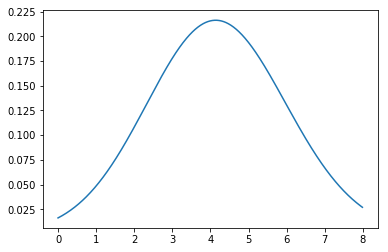

In [210]:
param_range = np.arange(0, 8.0, 0.01).reshape(-1,1)
plt.plot(param_range, posterior.eval(param_range, log=False))